# An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale

In this sequence of notebooks we try to reproduce the results of Dosovitskiy et al.‘s 2020 paper, “An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale”. [arXiv preprint arXiv:2010.11929](https://arxiv.org/abs/2010.11929). To create the interactive content for this notebook, we used the model checkpoints available on the authors’ [official repository](https://github.com/google-research/vision_transformer#vision-transformer-and-mlp-mixer-architectures).

------------------------------------------------------------------------

# Goals 🎯

The objective of this notebook is to show you how to:

-   Critically analyze the qualitative and quantitative claims in the research paper
-   Specify the experiments that are required to verify each claim
-   Identify the data, code, and hyperparameters that are necessary to run each experiment
-   Use pre-trained models to validate claims that need high computational resources
-   Determine the feasibility of verifying different types of claims
-   Design new experiments to validate the qualitative claims when some models or datasets are unavailable

**To assess the reproducibility level of this paper, we need to answer some questions while experimenting:**

-   Is there code available for both training and inference stages?
-   Is the code written by the authors themselves, or by someone else? Are there multiple implementations available for comparison?
-   What framework and version was used by the authors? Are all the functions still available or do we need to make some modifications?
-   Did the authors compare their model to other models that are not implemented in the code? Are these models available elsewhere?
-   Are all the hyperparameters for all the experiments clearly specified? If not, how sensitive is each hyperparameter to the performance?
-   Were the initial values set randomly or deterministically?
-   Are the datasets used by the authors accessible? Are there any preprocessing steps or modifications done to the data?
-   Did we obtain the same results as reported in the original paper?

# Introduction 📢

In the paper “An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale” by Dosovitskiy et al. present an innovative approach to applying the transformer architecture to computer vision tasks. Originally designed for natural language processing, the transformer architecture is a type of neural network that uses a parallel multi-head attention mechanism to process sequential data. Introduced in the 2017 paper [“Attention Is All You Need” by Vaswani et al.](https://arxiv.org/abs/1706.03762), it has since become widely used in natural language processing tasks.

------------------------------------------------------------------------

## Transformers

The transformer architecture uses an encoder-decoder structure that does not rely on recurrence and convolutions to generate an output. The encoder maps an input sequence to a series of continuous representations, which are then fed into the decoder. The decoder receives the encoder’s output and generates an output sequence based on it and the decoder’s output at a previous time step. For a more in-depth understanding of transformers, you can check out this [lecture by Sebastian Raschka](https://sebastianraschka.com/blog/2021/dl-course.html#l19-self-attention-and-transformer-networks), which is part of his Introduction to Deep Learning course.

------------------------------------------------------------------------

## Vision Transformers

The Vision Transformer (ViT) is a novel approach to image classification that uses a transformer encoder to directly process images, without the need for [convolutional neural networks (CNNs)](https://arxiv.org/abs/1511.08458). The image is first divided into equal-sized patches, which are then converted into vectors using a linear projection. Position embeddings are added to the patch vectors to preserve their spatial information, and the resulting sequence of vectors is fed into a standard transformer encoder to produce the image representation. The feature vector of a special classification token is used as the image representation, with a classification head added on top.

| 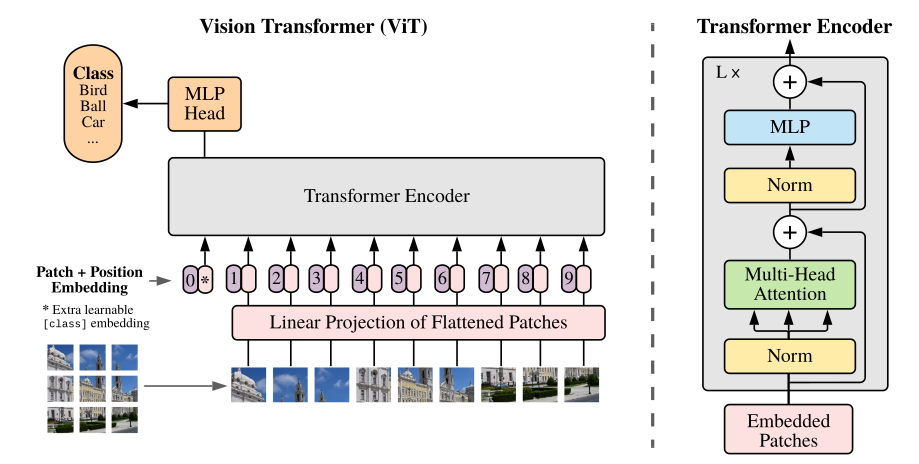                                                                                            |
|:-----------------------------------------------------------------------|
| *This is figure 1 from the original paper which illustrates process of image classification using a transformer encoder.* |

------------------------------------------------------------------------

**Even though both CNNs and ViT pay attention to the spatial organization of an image, they represent images in different ways. Can you explain the difference between these representation? 🤔**

## Visualization

In a vision transformer, an image is preprocessed through several steps before being fed into the transformer encoder. The first step involves dividing the image into fixed-size patches. These patches are then linearly embedded and combined with positional embeddings. This process is visualized below, where you can see how the patches look like. If you are interested in learning more about how positional embeddings are added to the patch embeddings and how attention is visualized, make sure to check out the [full tutorial](https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb).

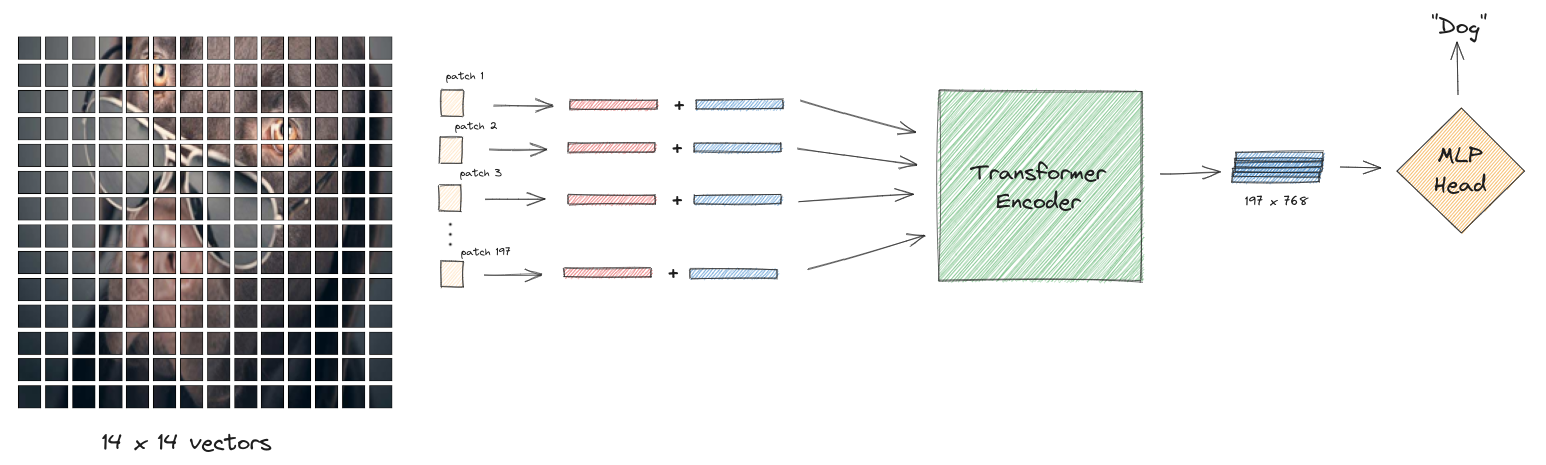

Suppose we have an image of size `H x W x C`, where `H` and `W` are the height and width of the image, respectively, and `C` is the number of channels. The image is first split into non-overlapping patches of size `P x P`, where `P` is the patch size. This results in a total of `(H x W) / (P x P)` patches, each of size `P x P x C`. Splitting the image into non-overlapping patches of size `P x P` is similar to using a 2D convolutional layer with a kernel size of `P x P` and a stride of `P x P`.

In [ ]:
import PIL
import matplotlib.pyplot as plt
# upload your image here
img = PIL.Image.open('image_path')
# Resize image to 224x224
img = img.resize((224, 224))
# Print image before any changes
plt.imshow(img)

In [ ]:
# The following code shows how each patch should look like
import numpy as np
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

After all patches have been created, positional embeddings are added to the patch embeddings. The positional embeddings are learnable parameters that encode the spatial position of each patch within the image. This allows the transformer to take into account the spatial relationships between patches when processing the image.

The resulting sequence of patch embeddings, along with an additional learnable class token, is then passed as input to the transformer. The transformer processes this sequence using self-attention and feedforward layers to produce a final representation for the image.

## ViT Reproduction

Dosovitskiy et al. demonstrate that **ViT** can achieve *state-of-the-art* results on image classification tasks, while requiring significantly less computational resources to train than **CNNs**. They also show that the key factor for **ViT’s** success is the scale of the pre-training dataset. When pre-trained on large-scale image datasets, such as **ImageNet-21k** or **JFT-300M**, and then fine-tuned on smaller downstream datasets, **ViT** attains significant improvements over **CNNs** that were available in that time. The authors also conduct extensive experiments to analyze the properties and behaviors of **ViT**, such as its attention patterns, transferability, and robustness.

------------------------------------------------------------------------

In this sequence of notebooks we will reproduce the authors results to verify the claims made in the paper. Even though **ViT** requires less computation than **CNNs**, replicating the authors’ work will still require a lot of computational resources, especially for pre-training on large-scale image datasets. The table below shows the required resources to train each model used in the paper. The values of `TPUv3-core-days` indicate how many days it would take to pre-train each model on a *single TPUv3* core, which is a specialized hardware accelerator for deep learning.

|      Model      | Paper-JFT (ViT-H/14) | Paper-JFT. (ViT-L/16) | Paper-I21k (ViT-L/16) | BiT-L (ResNet152x4) | Noisy Student (EfficientNet-L2) |
|:--:|:-----------:|:-----------:|:-----------:|:----------:|:-----------------:|
| TPUv3-core-days |         2.5k         |         0.68k         |         0.23k         |        9.9k         |              12.3k              |

Therefore, it will be better to actually use the *pre-trained models available* and fine-tune them in order to test the authors’ claims. The authors have released their pre-trained models and code on [GitHub](https://github.com/google-research/vision_transformer#vision-transformer-and-mlp-mixer-architectures), which can be easily adapted to different image classification tasks. By using the pre-trained models, one can save time and resources, and also test the generalization and robustness of **ViT**.

It is important to note that even if we wanted to pretrain the models again to test the computational claims made in the paper, it would not be possible because the authors used the **JFT-300M** dataset for pretraining, which is a private dataset only available to Google. However, the authors have released pre-trained models on the **ImageNet-21k** dataset, which are publicly available. In the following notebooks, we will use these pre-trained models to try and reproduce the results found in the paper.

------------------------------------------------------------------------